In [308]:
import os
import numpy as np
from numpy.linalg import eigvalsh
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, kron
from itertools import product, combinations
import plotly.graph_objects as go

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 14})  # Change 12 to the desired font size
# Enable LaTeX rendering in Matplotlib
plt.rc('text', usetex=True)
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm

np.set_printoptions(edgeitems=10)  # Set the number of elements at the beginning and end of each dimension when repr is called
np.set_printoptions(threshold=1000)  # Set the total number of array elements which trigger summarization rather than full repr
np.set_printoptions(precision=2)  # Set the precision for floating point output


<h3>The goal is to implement a function that does MDS using the coupling strength of the approximate 2-local form found for an initial Hamiltonian.<h3>

At first all parts of the MDS process are exposed. Then I put it all in one function


We start with loading the couplings and defining the total coupling strength table by summing the contributions from different interactions.

We also look at the coupling graph and create a re-scaled graph.

The $Jab$ matrix is expressed as a colored graph. We then create $w$ which is $-\log(J_{ab}/max_{ab}(J_{ab}))$. It weights couplings such that two vertices have high edge weight if they have low coupling strengh and vice versa. The log and renomalizing by the max(Jab) means we have 2 points with 0 distance by definition. The choice of function for re-weighting is already loaded with intent.



In [309]:
N = 12 # system size
k = 0 # sample number
letters = ['1', 'X', 'Y', 'Z']

J = abs(np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[1], letters[3])))
for a,b in [(1,1),(2,2),(3,3),(3,1)]:
    Jab = abs(np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b])))
    J+=Jab

#threshold = 1e-4  # Set this to the threshold you want to use
#Jab[np.abs(Jab) < threshold] = 0

Jab=J

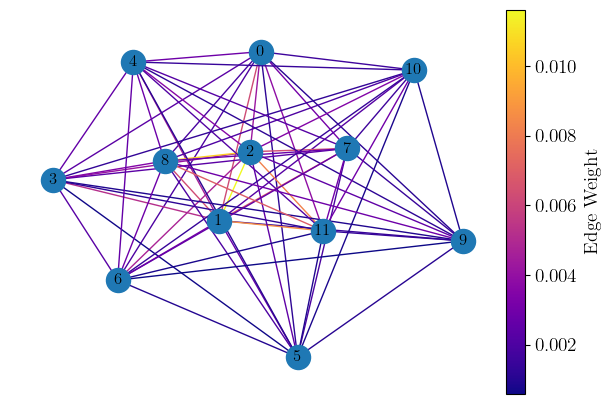

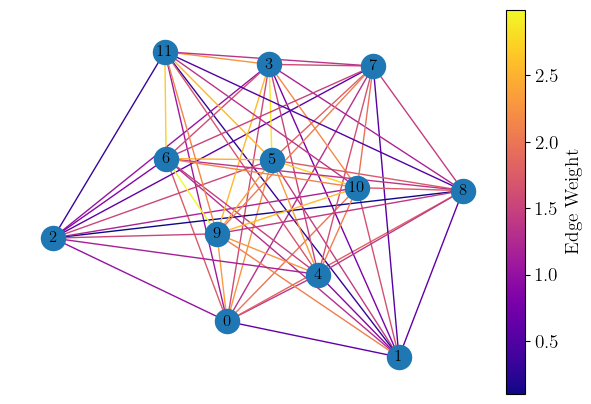

In [310]:
def define_graph(Jab):
    # Create a graph from Jab
    G = nx.from_numpy_array(Jab)

    edge_colors = [float(e[2]['weight']) for e in G.edges(data=True)]
    cmap = plt.cm.plasma  # You can choose any colormap you prefer

    # Create figure and axes
    fig, ax = plt.subplots()

    # Draw the graph with edge colors based on weight
    nx.draw(G, with_labels=True, edge_cmap=cmap, edge_color=edge_colors, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), ax=ax)

    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    fig.colorbar(sm, cax=cbar_ax, label='Edge Weight')
    plt.show()


define_graph(Jab)

def re_weighing(Jab):
    #Define the matrix w which has weights such that closer points have lower weight.
    N=Jab.shape[0]
    J_0=np.max(Jab)
    Jab=Jab/J_0
    w=np.zeros((N,N))
    for i in range(0,N):
        for j in range(i+1,N):
            #w[i,j]=1/((Jab[i,j]+1e-6))^2
            w[i,j]=-np.log(Jab[i,j]) 
            w[j,i]=w[i,j]
    return w
w=re_weighing(Jab)
define_graph(w)


For the distance function, we do the same as in the paper by Charles and Carroll $$d(a,b)=min_P(\sum_{i} w(p_i,p_{i+1}))$$ 

Here we have a function to find all paths of length < l  that go from a verte to another. Then we feed this to another function that calculates the total weight of that path. We use this to define the distance.

In [311]:
import numpy as np


def find_all_paths(w, start_vertex, end_vertex, l, path=[]):
    path = path + [start_vertex]
    if start_vertex == end_vertex or len(path) == l:
        if path[-1] == end_vertex:  # Only consider paths that end at the end_vertex
            return [(path)] #return [(path, weight)]
        else:
            return []
    paths = []
    for node in range(w.shape[0]):
        if node not in path:
            newpaths = find_all_paths(w, node, end_vertex, l, path)
            for newpath in newpaths:
                paths.append(newpath)
    
    return paths

def calculate_path_weight(w, path):
    total_weight = 0
    for i in range(len(path) - 1):
        start_vertex = path[i]
        end_vertex = path[i+1]
        total_weight += w[start_vertex][end_vertex]
    return total_weight

def distance(w):
    dab=w
    for a in range(dab.shape[0]):
        for b in range(dab.shape[1]):
            weights = [calculate_path_weight(w, path) for path in find_all_paths(w, a, b, 5)]
            if a==b:
                dab[a][b]=0
            else:
                dab[a][b]=min(weights)
    return dab

# Specify the start and end vertices
#start_vertex = 0
#end_vertex = 2
#all_paths = find_all_paths(Jab, start_vertex, end_vertex,3)
#for path in all_paths:
#    print(f"Path: {path}")

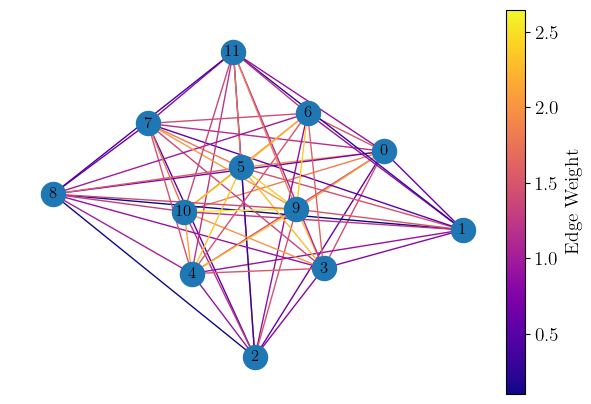

In [312]:
dab=distance(w)
define_graph(dab)

We now ask weather this graph with a distance defined on it approximates a smooth manifold of dim D

We take the MDS approach, and follow a procedure to embedd a graph with distance into a Euclidean manifold.
We again follow the paper and define matrix B,
$$B_{pq}=-\frac{1}{2}(d(p,q)^2-\frac{1}{N}\sum^{N}_{l=1}d(p,l)^2-\frac{1}{N}\sum^{N}_{l=1}d(l,q)^2+\frac{1}{N^2}\sum^N_{l,m=1}d(l,m)^2)$$

From $B$ we contruct $X$
$$X=(\sqrt{\lambda_1}v_1,\sqrt{\lambda_2}v_2...)$$

Note, I took the absolute values of eigenvalues

In [313]:
def calculate_B(dab):
    N = len(dab)
    B = [[0 for _ in range(N)] for _ in range(N)]
    
    for p in range(N):
        for q in range(N):
            if p == q:
                continue
            d_pq = dab[p][q]
            d_p_sum = sum([dab[p][l]**2 for l in range(N)])
            d_q_sum = sum([dab[l][q]**2 for l in range(N)])
            d_sum = sum([dab[l][m]**2 for l in range(N) for m in range(N)])
            B[p][q] = -0.5 * (d_pq**2 - (d_p_sum + d_q_sum) / N + d_sum / (N**2))
    return B

def calculate_X(B):
    N = np.shape(B)[0]
    X = np.zeros((N, N))

    eigenvalues, eigenvectors = np.linalg.eig(B)
    #TODO should I keep the negative eigenvalues?
    eigenvalues=abs(eigenvalues)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]
    
    for i in range(N):
        X[:, i] = np.sqrt(eigenvalues[i]) * eigenvectors[:, i]
    return X

def eigenvalues(B):
    eigenvalues, _ = np.linalg.eig(B)
    eigenvalues=abs(eigenvalues)
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    return eigenvalues


We plot the eigenvalues in descending order so as to get an idea for the dominant dimensions

Text(0.5, 1.0, 'Scatter plot of eigenvalues')

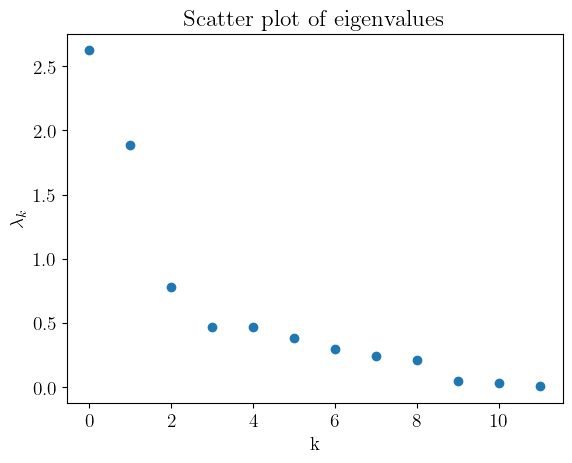

In [314]:
Bab=calculate_B(dab)
eig=eigenvalues(Bab)
Xab=calculate_X(Bab)

plt.scatter(range(len(eig)),eig)
plt.ylabel(f'$\lambda_k$')
plt.xlabel("k")
plt.title("Scatter plot of eigenvalues")


X is our coordinate matrix, we use it to calculate euclidean distances

We need an X defined for a D dimensional space. To get it, we use the scatter plot of eigenvalues and cut-off the relavant non-dominant columns of X.

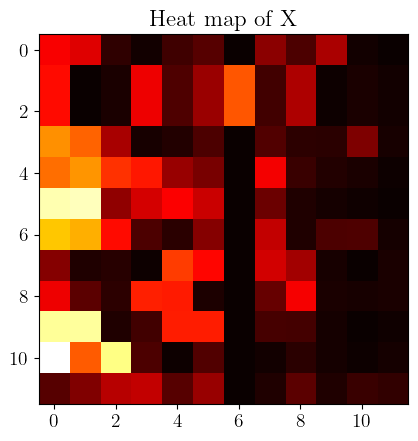

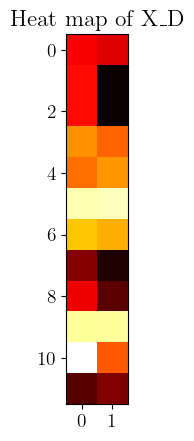

In [315]:
def get_X_D(X,D):
    #We defined here X but only with the first D columns.
    N=np.shape(X)[0]
    if D > N:
        raise ValueError("D exceeds the number of columns in X.")
    X_D = X[:, :D]
    return X_D

D = 2
X_D=get_X_D(Xab,D)

plt.imshow(abs(Xab), cmap='hot', interpolation='nearest')
plt.title("Heat map of X")
plt.show()

plt.imshow(abs(X_D), cmap='hot', interpolation='nearest')
plt.title("Heat map of X_D")
plt.show()


From X_D we can define the euclidean distance between the points in out D dimensional space $d_e(p,q)=\sqrt{\sum^D_{r=1}(X_{pr}-X_{qr})^2}$


In [316]:
def euclidean_distance(X):
    N, D = X.shape
    d_e = np.zeros((N, N))

    for p in range(N):
        for q in range(p+1, N):
            diff = X[p] - X[q]
            d_e[p, q] = np.sqrt(np.sum(diff**2))
            d_e[q, p] = d_e[p, q]
    return d_e

In [317]:
d_e=euclidean_distance(X_D)

We can now introduce the stress function, a way to estimate distortion necessary to embedd our graph in our D dim space.
$$stress=\sqrt{\frac{(\sum_{p,q}d(p,q)d_e(p,q))^2}{(\sum_{p,q}d(p,q))^2(\sum_{p,q}d_e(p,q))^2}}$$

Or we can use 
$$\epsilon_D=1-\frac{\sum^D_i\lambda_i}{\sum^N_i\lambda_i}$$

The smaller the better.

The stress for D = 2 is : 0.39373492091025375


Text(0, 0.5, '$\\epsilon$')

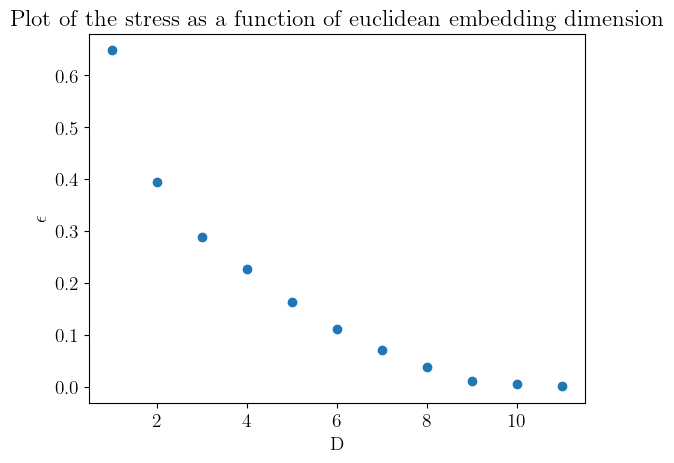

In [318]:

def epsilon(D,eig):
    epsilon = 1-np.sum(abs(eig[:D]))/np.sum(abs(eig))
    return epsilon


print(f"The stress for D = {D} is : {epsilon(D,eig)}")
# we calculate the value of the stress for different chosen effective dimensions D
stress_list=[]
for d in range(1,N):
    stress_list.append(epsilon(d,eig))

plt.scatter(range(1,N),stress_list)
plt.title("Plot of the stress as a function of euclidean embedding dimension")
plt.xlabel("D")
plt.ylabel(f"$\epsilon$")
#From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
#In our case we woudl get D=5

We also introduce a function to plot our coordinates in 3D space using the euclidean distance.


In [319]:
def plot_3D_points(X):
    X_3=get_X_D(X,3)
    fig = go.Figure(data=go.Scatter3d(x=X_3[:, 0], y=X_3[:, 1], z=X_3[:, 2], mode='markers'))
    fig.update_layout(title='3D Plot of Points', scene=dict(xaxis=dict(title='X-axis'),
                                                         yaxis=dict(title='Y-axis'),
                                                         zaxis=dict(title='Z-axis')))
    fig.show()

In [320]:
plot_3D_points(Xab)

In [325]:
def MDS(Jab,cuttoff):
    
    print("Graph of Jab")
    define_graph(Jab)

    w=re_weighing(Jab)
    print("re-scaled graph of Jab")
    define_graph(w)


    dab=distance(w)
    print("Graph of distances")
    define_graph(dab)

    Bab=calculate_B(dab)
    eig=eigenvalues(Bab)
    Xab=calculate_X(Bab)

    plt.scatter(range(len(eig)),eig)
    plt.ylabel(f'$\lambda_k$')
    plt.xlabel("k")
    plt.title("Scatter plot of eigenvalues")
    plt.show()
    #TODO define a function to get a D estimate from the cuttoff.
    
    stress_list=[]
    for d in range(1,N):
        stress_list.append(epsilon(d,eig))

    plt.scatter(range(1,N),stress_list)
    plt.title("Plot of the stress as a function of euclidean embedding dimension")
    plt.xlabel("D")
    plt.ylabel(f"$\epsilon$")
    plt.show()

    # we calculate the value of the stress for different chosen effective dimensions D

    D_eff=0
    for index, value in enumerate(stress_list):
        if value > cuttoff:
            D_eff= index+2
    

    print(f"Using cut-off:{cuttoff} we get D = {D_eff}")
    print(f"The stress for D = {D_eff} is : {epsilon(D_eff,eig)}")
    #From this we can creat an arbitrary condition on a dimension being appropriate. ie D = the first D such that stress<0.2?
    #In our case we woudl get D=5

    plot_3D_points(Xab)
    

Graph of Jab


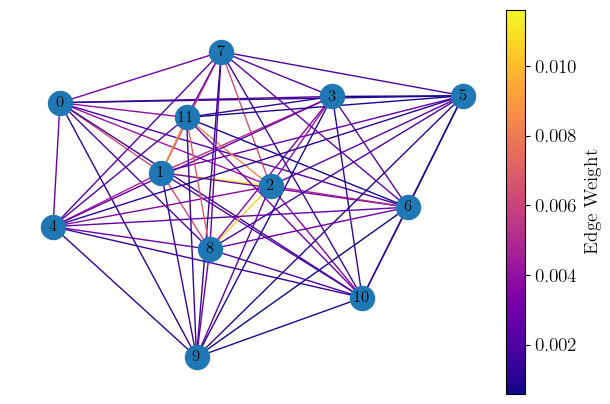

re-scaled graph of Jab


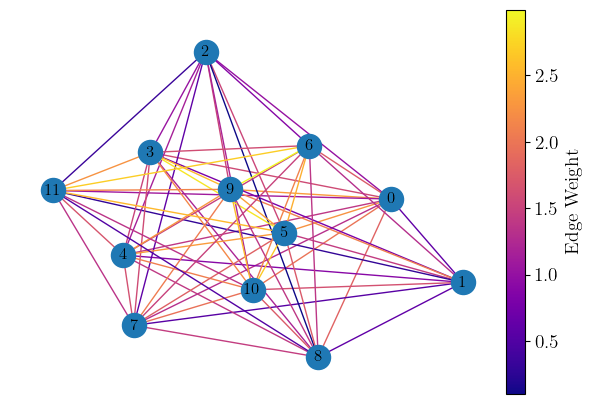

Graph of distances


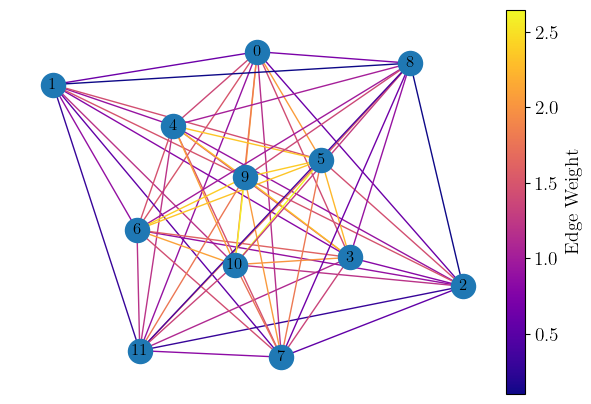

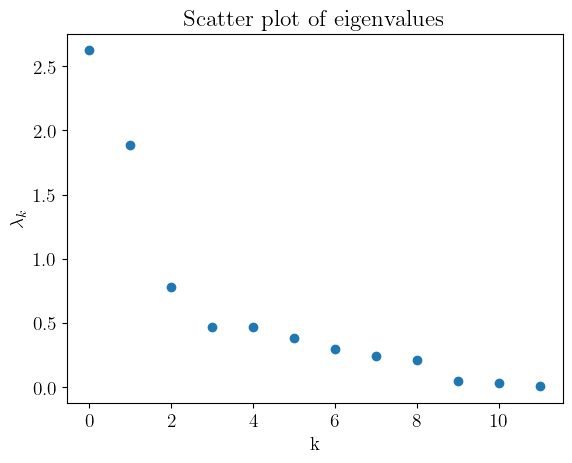

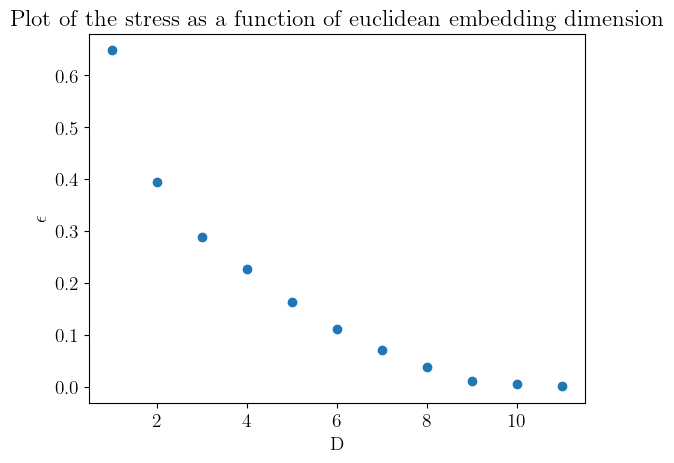

Using cut-off:0.3 we get D = 3
The stress for D = 3 is : 0.28850119380603734


In [326]:
N = 12 # system size
k = 0 # sample number
letters = ['1', 'X', 'Y', 'Z']

J = abs(np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[1], letters[3])))
for a,b in [(1,1),(2,2),(3,3),(3,1)]:
    Jab = abs(np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b])))
    J+=Jab

#threshold = 1e-4  # Set this to the threshold you want to use
#Jab[np.abs(Jab) < threshold] = 0

Jab=J

MDS(Jab,0.3)